In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os

from scipy import optimize

In [2]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)

if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2022-el8-x86_64/bin/x86_64-linux/"

COLORS = ["f07167","219ebc","c767ac","ffba0a","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load tables

In [3]:
DIR = '/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/'

In [4]:
def func(X):
    
    med = np.median(X, axis = 0)
    upp = np.percentile(X, 84, axis = 0) - med
    low = np.percentile(X, 16, axis = 0) - med
    
    upp = upp * np.sqrt(len(X))
    low = low * np.sqrt(len(X))
    
    return med, upp, low


def fitter(X):
    
    def tmp(x, pi, alpha):
        
        return pi + x*alpha
        
    
    res = []
    
    for i in range(X.shape[1]):
        p1 = optimize.curve_fit(tmp, X[0, i], X[1, i])
        p2 = optimize.curve_fit(tmp, X[0, i], X[2, i])
        
        res.append([p1[0], p2[0]])
    
    res = np.array(res)
    return res


def jacktrans(x):
    
    x = x + (x - np.mean(x, axis = 0)) * np.sqrt(len(x))
    
    return x

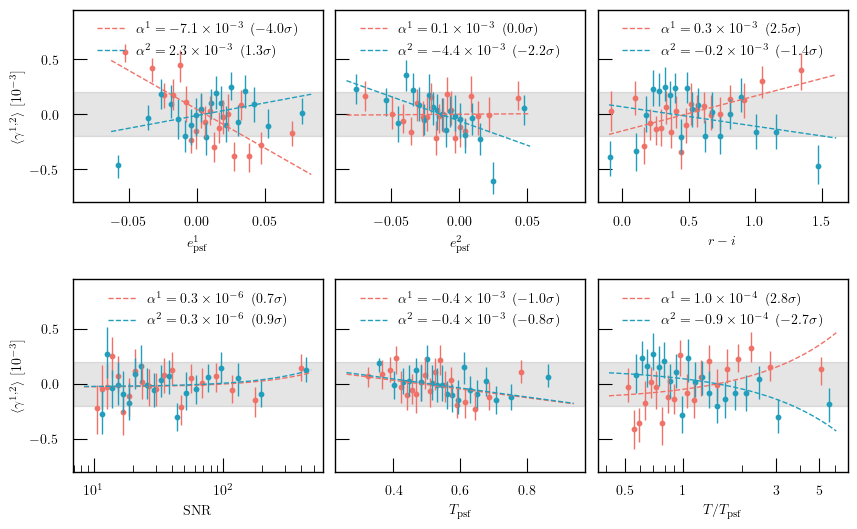

In [5]:

fig, ax = plt.subplots(2, 3, figsize = (10, 6), sharey = True)
ax = ax.flatten()
plt.subplots_adjust(hspace = 0.4, wspace = 0.05)

ax[0].sharex(ax[1])


files = ['e_vs_e1psf', 'e_vs_e2psf', 'e_vs_r_minus_i',  'e_vs_SNR', 'e_vs_Tpsf', 'e_vs_Tratio']

for i in range(len(files)):
    
    Y = np.load(os.path.join(DIR, files[i] + '.npy'))

    X = func(Y[0])[0]
    
    med, upp, low = func(Y[1] * 1e3)
    ax[i].scatter(X, med, s = 10)
    ax[i].errorbar(X, med, yerr = [upp, np.abs(low)], lw = 0, elinewidth = 1)
    
    
    med, upp, low = func(Y[2] * 1e3)
    ax[i].scatter(X * (1 + 0.1), med, s = 10)
    ax[i].errorbar(X * (1 + 0.1), med, yerr = [upp, np.abs(low)], lw = 0, elinewidth = 1)
    
    
    x = np.linspace(np.min(X) * (0.8 if min(X) > 0 else 1.2), np.max(X) *1.2, 100)
    res = jacktrans(fitter(Y))
    med = np.median(res, axis = 0)
    sig = med/np.std(res, axis = 0)
    
    if files[i] == 'e_vs_SNR':
        ax[i].plot(x, (med[0, 0] + med[0, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[0], label = r'$\alpha^1 = %0.1f \times 10^{-6} \,\,\,(%0.1f\sigma)$' % (med[0, 1] * 1e6, sig[0, 1]))
        ax[i].plot(x, (med[1, 0] + med[1, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[1], label = r'$\alpha^2 = %0.1f \times 10^{-6} \,\,\,(%0.1f\sigma)$' % (med[1, 1] * 1e6, sig[1, 1]))
        
    elif files[i] == 'e_vs_Tratio':
        ax[i].plot(x, (med[0, 0] + med[0, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[0], label = r'$\alpha^1 = %0.1f \times 10^{-4} \,\,\,(%0.1f\sigma)$' % (med[0, 1] * 1e4, sig[0, 1]))
        ax[i].plot(x, (med[1, 0] + med[1, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[1], label = r'$\alpha^2 = %0.1f \times 10^{-4} \,\,\,(%0.1f\sigma)$' % (med[1, 1] * 1e4, sig[1, 1]))
    
    else:
        ax[i].plot(x, (med[0, 0] + med[0, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[0], label = r'$\alpha^1 = %0.1f \times 10^{-3} \,\,\,(%0.1f\sigma)$' % (med[0, 1] * 1e3, sig[0, 1]))
        ax[i].plot(x, (med[1, 0] + med[1, 1]*x) * 1e3, ls = '--', lw = 1, color = COLORS[1], label = r'$\alpha^2 = %0.1f \times 10^{-3} \,\,\,(%0.1f\sigma)$' % (med[1, 1] * 1e3, sig[1, 1]))
    
    ax[i].legend(fontsize = 10, frameon = False, loc = 'upper center')

[ax[i].set_ylim(ax[i].get_ylim()[0], ax[i].get_ylim()[1] * 1.05) for i in range(len(ax))]
    
    
ax[0].set_xlabel(r'$e^{1}_{\rm psf}$', size = 10, labelpad = 5)
ax[1].set_xlabel(r'$e^{2}_{\rm psf}$', size = 10, labelpad = 5)
ax[2].set_xlabel(r'$r-i$', size = 10, labelpad = 5)
ax[3].set_xlabel(r'SNR', size = 10, labelpad = 5)
ax[4].set_xlabel(r'$T_{\rm psf}$', size = 10, labelpad = 5)
ax[5].set_xlabel(r'$T/T_{\rm psf}$', size = 10, labelpad = 5)

[a.axhspan(-0.2, 0.2,  color = 'k', alpha = 0.1, zorder = -1000) for a in ax]

ax[0].set_ylabel(r'$\langle \gamma^{1,2}\rangle$  [$10^{-3}$]', size = 10)
ax[3].set_ylabel(r'$\langle \gamma^{1,2}\rangle$  [$10^{-3}$]', size = 10)

ax[3].set_xscale('log')
ax[5].set_xscale('log')

[a.tick_params(pad = 10) for a in ax.flat]

ax[5].set_xticks([0.5, 1, 3, 5])
ax[5].set_xticklabels([0.5, 1, 3, 5])
plt.savefig('./Shear_vs_mcalX.pdf', dpi = 300, bbox_inches = 'tight')